# Data Preprocessing

In [1]:
import pandas as pd

# Load data
df = pd.read_csv("/Users/willjettinghoff/Desktop/WiseJudgement/Prelim Data/WJC_firstwave_merged_with_original.csv")

# Define prompts
prompts = [
    "1. What was this difficult decision about? Please describe in detail who was involved, where and when it took place, and what was happening at that time.",
    "2. What specific issues did you encounter when making this difficult decision?",
    "3. What were you thinking when you first encountered this difficult decision?",
    "4. What were you feeling when you first encountered this difficult decision?",
    "5. If you are comfortable sharing, what steps did you take to address this difficult decision?",
    "6. In what ways did this difficult decision affect your life?",
    "7. Is there anything else you would like to share about this difficult decision?"
]

# Merge original-language responses
def merge_open_responses_original(df):
    """
    Merge original-language open-ended responses from either the 'LB' or 'SMB' source format into a unified set of columns.

    For each of the 7 open-ended questions, this function selects the response from 'LB_Open_Q{i}_original' 
    if any are non-missing, otherwise it selects from 'SMB_Open_Q{i}_original'. The resulting values are stored 
    in 'Open_{i}_original'. Additionally, a new column 'open_type_original' is created to indicate the source 
    ('LB' or 'SMB').

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing original-language open-ended responses.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged original-language responses and source label, with the original LB/SMB columns removed.
    """
    lb = [f'LB_Open_Q{i}_original' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}_original' for i in range(1, 8)]
    target = [f'Open_{i}_original' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_original'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Merge English-translated responses
def merge_open_responses_en(df):
    """
    Merge English-translated open-ended responses from either the 'LB' or 'SMB' source format into a unified set of columns.

    For each of the 7 open-ended questions, this function selects the response from 'LB_Open_Q{i}' 
    if any are non-missing, otherwise it selects from 'SMB_Open_Q{i}'. The results are stored in 
    'Open_{i}_en'. A new column 'open_type_en' indicates the response source ('LB' or 'SMB').

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing English-translated open-ended responses.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged English responses and source label, with the original LB/SMB columns removed.
    """
    lb = [f'LB_Open_Q{i}' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}' for i in range(1, 8)]
    target = [f'Open_{i}_en' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_en'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Concatenate prompt + response strings
def concatenate_open_responses(df, prefix):
    """
    Concatenate prompt–response pairs into unified narrative fields for open-ended survey responses.

    Constructs two string fields:
    1. 'all_open_{prefix}' — a full concatenation of all 7 prompts with their corresponding responses.
    2. 'Open_Q1_2_{prefix}' — a partial concatenation using only the first two prompts and responses.

    Prompts are fixed; responses are drawn from 'Open_{i}_{prefix}' for i in 1–7. Missing responses 
    are replaced with 'No response.'. Excess whitespace is removed.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with open-ended response columns already merged and labeled.
    prefix : str
        Column suffix indicating response language/context (e.g., 'original' or 'en').

    Returns
    -------
    pandas.DataFrame
        DataFrame with two new columns containing concatenated prompt–response strings.
    """
    response_cols = [f'Open_{i}_{prefix}' for i in range(1, 8)]

    # Full concatenated text
    df[f'all_open_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('<NA>') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('<NA>') + " " +
        prompts[2] + " " + df[response_cols[2]].fillna('<NA>') + " " +
        prompts[3] + " " + df[response_cols[3]].fillna('<NA>') + " " +
        prompts[4] + " " + df[response_cols[4]].fillna('<NA>') + " " +
        prompts[5] + " " + df[response_cols[5]].fillna('<NA>') + " " +
        prompts[6] + " " + df[response_cols[6]].fillna('<NA>')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    # Q1 + Q2
    df[f'Open_Q1_2_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('<NA>') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('<NA>')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    return df

# Execute full pipeline
df = (
    df
    .pipe(merge_open_responses_original)
    .pipe(merge_open_responses_en)
    .loc[lambda d: d[[f'Open_{i}_original' for i in range(1, 8)]].notna().any(axis=1)]
    .reset_index(drop=True)
)

df = concatenate_open_responses(df, prefix='original')
df = concatenate_open_responses(df, prefix='en')

# Create versions of Q1+Q2 without prompt text
df['Open_Q1_2_original_noQ'] = (
    df['Open_1_original'].fillna('<NA>') + " " +
    df['Open_2_original'].fillna('<NA>')
).str.replace(r'\s+', ' ', regex=True).str.strip()

df['Open_Q1_2_en_noQ'] = (
    df['Open_1_en'].fillna('<NA>') + " " +
    df['Open_2_en'].fillna('<NA>')
).str.replace(r'\s+', ' ', regex=True).str.strip()

import re

def clean_text(text):
    """
    Remove unwanted artifacts from text using regex.

    Artifacts removed:
    - '&#xa' and '&#xa;'
    - 'xml:space="preserve"' and 'xml:space="preserve">'
    - '_x000D_'
    """
    if pd.isnull(text):
        return text
    return re.sub(r'(&#xa;?|xml:space="preserve">?|_x000D_)', '', text)

columns_to_clean = [ # this is all the text variables, group by type (original language or english translation)
    'Norm_Q_original', 'Open_1_original', 'Open_2_original', 'Open_3_original',
    'Open_4_original', 'Open_5_original', 'Open_6_original', 'Open_7_original',
    'Norm_Q', 'Open_1_en', 'Open_2_en', 'Open_3_en', 'Open_4_en',
    'Open_5_en', 'Open_6_en', 'Open_7_en', 'all_open_original',
    'Open_Q1_2_original', 'all_open_en', 'Open_Q1_2_en',
    'Open_Q1_2_original_noQ', 'Open_Q1_2_en_noQ'
]

df[columns_to_clean] = df[columns_to_clean].applymap(clean_text)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 87 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Language                1806 non-null   object 
 1   StartDate               1806 non-null   object 
 2   EndDate                 1806 non-null   object 
 3   IPAddress               1806 non-null   object 
 4   Progress                1806 non-null   int64  
 5   Duration..in.seconds.   1806 non-null   int64  
 6   Finished                1806 non-null   bool   
 7   RecordedDate            1806 non-null   object 
 8   ResponseId              1806 non-null   object 
 9   RecipientLastName       158 non-null    object 
 10  RecipientFirstName      158 non-null    object 
 11  RecipientEmail          158 non-null    object 
 12  ExternalReference       158 non-null    object 
 13  LocationLatitude        1806 non-null   object 
 14  LocationLongitude       1806 non-null   

/var/folders/_l/01s2ywxs5tj9v5v4r4cg9z4w0000gn/T/ipykernel_1866/40357670.py:170: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_clean] = df[columns_to_clean].applymap(clean_text)


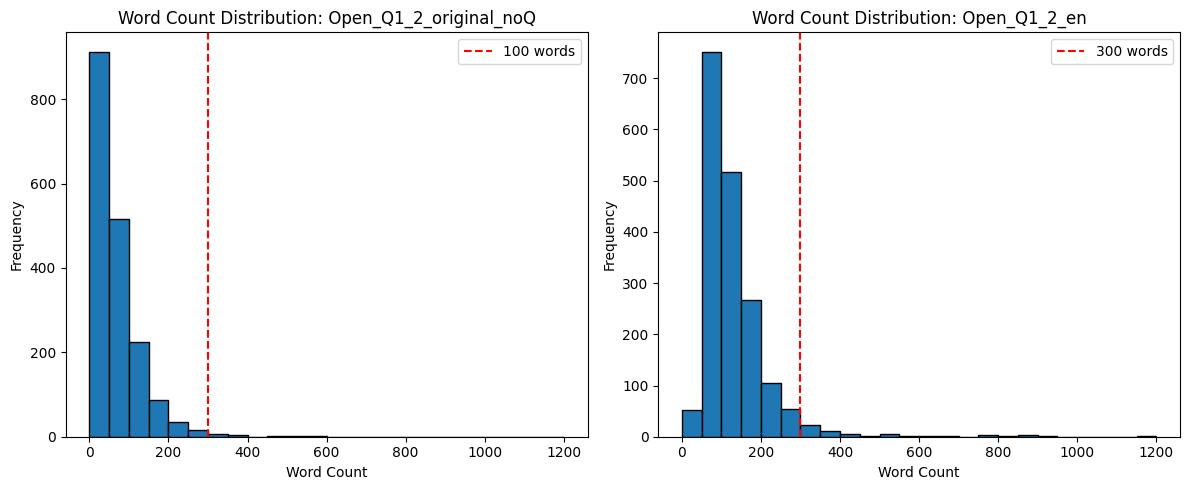

word_count_original_noQ: 15 responses over limit of words (2.49%)
word_count_en: 59 responses over limit of words (9.80%)


In [2]:
df[['Open_Q1_2_original_noQ', 'Open_Q1_2_en']].apply(lambda col: col.str.split().str.len())


df['word_count_original_noQ'], df['word_count_en'] = (
    df['Open_Q1_2_original_noQ'].str.split().str.len(),
    df['Open_Q1_2_en'].str.split().str.len()
)

import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, max(df['word_count_original_noQ'].max(), df['word_count_en'].max()) + 50, 50)

plt.figure(figsize=(12, 5))

# Histogram for original language
plt.subplot(1, 2, 1)
plt.hist(df['word_count_original_noQ'].dropna(), bins=bins, edgecolor='black')
plt.axvline(300, color='red', linestyle='--', label='100 words')
plt.title('Word Count Distribution: Open_Q1_2_original_noQ')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

# Histogram for English translation
plt.subplot(1, 2, 2)
plt.hist(df['word_count_en'].dropna(), bins=bins, edgecolor='black')
plt.axvline(300, color='red', linestyle='--', label='300 words')
plt.title('Word Count Distribution: Open_Q1_2_en')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

for col in ['word_count_original_noQ', 'word_count_en']:
    total = df[col].notna().sum()
    over_384 = (df[col] > 300).sum()
    pct_over_384 = over_384 / total * 300 if total > 0 else 0
    print(f"{col}: {over_384} responses over limit of words ({pct_over_384:.2f}%)")



# Embed text

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os
from tqdm import tqdm

# --- token-based sliding windows ---
def chunk_text_by_tokens(text, tokenizer, window_size=128, overlap=64):
    """
    Split `text` into token windows of length `window_size`, overlapping by `overlap` tokens,
    using the model's tokenizer.
    """
    assert 0 <= overlap < window_size, "overlap must be in [0, window_size)"
    if text is None:
        text = ""
    # tokenize without adding special tokens so counts match the real content
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    if not token_ids:  # handle empty input: return one empty chunk
        return [""]

    step = window_size - overlap
    chunks = []
    for start in range(0, len(token_ids), step):
        window = token_ids[start : start + window_size]
        if not window:
            break
        # decode back to text for SentenceTransformer.encode
        chunk_text = tokenizer.decode(window, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        chunks.append(chunk_text)
        if start + window_size >= len(token_ids):
            break
    return chunks

def mean_pool_embeddings(embs):
    """
    L2-normalize each chunk embedding, average, then L2-normalize the pooled vector.
    """
    if len(embs) == 1:
        v = embs[0]
        # normalize single vector
        v = v / (np.linalg.norm(v) + 1e-12)
        return v
    # normalize per-chunk, then mean
    normed = [e / (np.linalg.norm(e) + 1e-12) for e in embs]
    pooled = np.mean(normed, axis=0)
    pooled = pooled / (np.linalg.norm(pooled) + 1e-12)
    return pooled

def compute_and_save_embeddings_sliding_meanpool(
    df,
    column_name,
    output_path,
    model,
    window_size=128,
    overlap=64,
    batch_size=64,
):
    """
    For each row: chunk by tokens (window_size, overlap), embed all chunks, mean-pool to one vector,
    save arrays {ids, embeddings} to .npz
    """
    ids = df["ID"].tolist()
    texts = df[column_name].fillna("").astype(str).tolist()
    tokenizer = model.tokenizer

    pooled_vectors = []
    dim = model.get_sentence_embedding_dimension()

    for text in tqdm(texts, desc=f"Embedding (ws={window_size}, ov={overlap})"):
        chunks = chunk_text_by_tokens(text, tokenizer, window_size=window_size, overlap=overlap)
        # encode all chunks for this document; normalize at the end (we normalize manually)
        chunk_embs = model.encode(
            chunks,
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=False,  # we control normalization
        )
        pooled = mean_pool_embeddings(chunk_embs)
        pooled_vectors.append(pooled)

    embeddings = np.vstack(pooled_vectors).astype(np.float32)
    np.savez_compressed(output_path, ids=np.array(ids), embeddings=embeddings)

# ---- usage ----
output_dir = '/Users/willjettinghoff/Desktop/WiseJudgement/Embeddings/Wave 1/'
target_columns = ['Open_Q1_2_original_noQ']
model_names = ['sentence-transformers/paraphrase-multilingual-mpnet-base-v2']

for model_name in model_names:
    model = SentenceTransformer(model_name)
    for col in target_columns:
        model_id = model_name.split("/")[-1]
        output_path = os.path.join(output_dir, f'emb_{col}_{model_id}_ws128_ov64_meanpool.npz')
        compute_and_save_embeddings_sliding_meanpool(
            df,
            column_name=col,
            output_path=output_path,
            model=model,
            window_size=128,
            overlap=64,
            batch_size=64  # adjust to your device
        )


Embedding (ws=128, ov=64): 100%|██████████| 1806/1806 [01:03<00:00, 28.56it/s]


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# LOCAL output directory: where to save embeddings on your machine. Example:
output_dir = '/Users/willjettinghoff/Desktop/WiseJudgement/Embeddings/Wave 1/' # 

def compute_and_save_embeddings(df, column_name, output_path, model, batch_size=32):
    """Reusable function for vectorizing a text variable and saving the embeddings.

    Args:
        df (_type_): Pandas dataframe
        column_name (_type_): your text variable
        output_path (_type_): local on your computer or shared drive
        model (_type_): the text embedding model
        batch_size (int, optional): The number of documents to be embed at once. Device dependant. Defaults to 32.
    """
    texts = df[column_name].fillna('').astype(str).tolist()
    ids = df['ID'].tolist()
    embeddings = model.encode(
        texts, # a text variable
        batch_size=batch_size, # number of documents to vectorize per batch
        show_progress_bar=True
        )
    np.savez_compressed(output_path, ids=np.array(ids), embeddings=embeddings)

# List of target columns and models
target_columns = ['Open_Q1_2_original_noQ'
                  ]
model_names = [
    'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
]

# For each model and column pair, embed the documents with the model on your computer
for model_name in model_names:
    model = SentenceTransformer(model_name)
    for col in target_columns:
        model_id = model_name.split("/")[-1]
        output_path = os.path.join(output_dir, f'emb_{col}_{model_id}.npz')
        compute_and_save_embeddings(df, col, output_path, model=model, batch_size=32)

Batches: 100%|██████████| 57/57 [00:20<00:00,  2.73it/s]


In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# Output directory for storing embeddings
output_dir = '/Users/willjettinghoff/Desktop/WiseJudgement/Embeddings/Wave 1/'

def compute_and_save_embeddings(df, column_name, output_path, model, batch_size=32, task='separation'):
    """Compute and save embeddings using a task-specific adapter."""
    texts = df[column_name].fillna('').astype(str).tolist()
    ids = df['ID'].tolist()
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        prompt_name=task,  # specify task-specific adapter
        max_length=1024,
        truncate_dim=768
    )
    np.savez_compressed(output_path, ids=np.array(ids), embeddings=embeddings)

# Define target text columns
target_columns = ['Open_Q1_2_original_noQ']

# Load Jina model with support for remote code
model_name = 'jinaai/jina-embeddings-v3'
model = SentenceTransformer(model_name, trust_remote_code=True)
model_id = model_name.split("/")[-1]

# Compute embeddings for each column using the 'separation' task
for col in target_columns:
    output_path = os.path.join(output_dir, f'emb_{col}_{model_id}_separation.npz')
    compute_and_save_embeddings(df, col, output_path, model=model, batch_size=8, task='separation')


/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 226/226 [02:09<00:00,  1.75it/s]


# Topic Modeling

In [ ]:
# Define the topic modeling pipeline
import tiktoken
import openai
import numpy as np
import torch
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import umap
import hdbscan

# Set global reproducibility seed
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)

# UMAP dimensionality reduction
# Reference: https://arxiv.org/pdf/1802.03426
# Implementation: https://umap-learn.readthedocs.io/en/latest/parameters.html#metric
umap_model = umap.UMAP(
    n_components=6,     # tunable: (3 levels: 4-7)
    n_neighbors=15,     # tunable: (4 levels: 10-20)
    min_dist=0.1,       # tunable: (4 levels levels: .01, .3)
    metric='cosine',    
    random_state=seed
) 

# HDBSCAN clustering
# Reference: 
# Implementation:

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples = 1, # 1 minimizes outliers
    metric='euclidean',
    cluster_selection_method='leaf',
    approx_min_span_tree=False, # must be off to have reproducibility
    prediction_data=True
)

# Vectorizer and transformation model
vectorizer = CountVectorizer(ngram_range=(2, 4), stop_words="english") # remove stopwords here, but not before the embedding
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Set-up GPT labelling
# Tokenizer
tokenizer= tiktoken.encoding_for_model("gpt-4o")
# Create your representation model
client = openai.OpenAI(api_key="<your_key>")

from bertopic.representation import OpenAI
import openai
prompt = """
You will extract a short topic label from given documents and keywords. 
*ALL* documents are survey responses to questions about a difficult life decision. Therefore, your goal is to determine a representative, specific, and distinctive label for the documents and keywords within the broader context of difficult life decisions.
Here are two examples of topics you created before for a similar dataset that was not about difficult life decisions:

# Example 1
Sample texts from this topic:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the worst food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

Keywords: meat beef eat eating emissions steak food health processed chicken
topic: Environmental impacts of eating meat

# Example 2
Sample texts from this topic:
- I have ordered the product weeks ago but it still has not arrived!
- The website mentions that it only takes a couple of days to deliver but I still have not received mine.
- I got a message stating that I received the monitor but that is not true!
- It took a month longer to deliver than was advised...

Keywords: deliver weeks product shipping long delivery received arrived arrive week
topic: Shipping and delivery issues

# Your task
Sample texts from this topic:
[DOCUMENTS]

Keywords: [KEYWORDS]

Based on the information above, extract a short topic label (three words at most) in the following format:
topic: <topic_label>"""

gpt = OpenAI(
    client,
    model="gpt-4o",
    delay_in_seconds=3,
    chat=True,
    nr_docs=5,
    doc_length=512,
    tokenizer=tokenizer,
    prompt=prompt
)

from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
mmr = MaximalMarginalRelevance(diversity=.9)
keybertins = KeyBERTInspired(top_n_words=20)

# Use one before GPT
representation_models = {
    # "keybertins":  keybertins,
    "mmr":  mmr,
    "gpt":  gpt,
}


# Define BERTopic model
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=mmr, # mmr for testing OR representation_models if using ChatGPT for topic labelling
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    top_n_words=10,
    calculate_probabilities=True,
    verbose=True)
        
        
# Apply topic modeling pipeline
import pandas as pd
import numpy as np


docs = df['Open_Q1_2_en_noQ'].astype(str) # this version of the text, without question text, is used for ctf-idf

# load corresponding precomputed embeddings
emb_data = np.load('/Users/willjettinghoff/Desktop/WiseJudgement/Embeddings/Wave 1/emb_Open_Q1_2_original_noQ_paraphrase-multilingual-mpnet-base-v2_ws128_ov64_meanpool.npz')
embeddings = emb_data['embeddings']  # get the actual embeddings, as opposed to the separate ID column


# Fit the BERTopic model to the documents and embeddings
topics, probabilities = topic_model.fit_transform(docs, embeddings) # emb_all_qs_original, emb_Q1_original

# Extract topic-term tf-idf matrix
topic_term_matrix = topic_model.c_tf_idf_

# Construct DataFrame with topic probabilities per document
# pretty sure this doesn't inlucded predicted probabilityes for outlier comments
df_probabilities = pd.DataFrame(probabilities, columns=[f"Topic_{i}" for i in range(probabilities.shape[1])])

# Combine with original comment-level metadata
df = pd.concat([df, df_probabilities], axis=1)

# Optionally save outputs
# df_combined.to_csv("/path/to/output/topic_probabilities.csv", index=False)
# topic_model.save("/path/to/output/bertopic_model", serialization="safetensors", save_ctfidf=True)

# To load a previously saved model
# topic_model = BERTopic.load("/path/to/output/bertopic_model")

/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-11 21:49:02,704 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-11 21:49:08,589 - BERTopic - Dimensionality - Completed ✓
2025-08-11 21:49:08,590 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-11 21:49:08,647 - BERTopic - Cluster - Completed ✓
2025-08-11 21:49:08,650 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-11 21:49:09,011 - BERTopic - Representation - Completed ✓


In [4]:
import bertopic

# produce a table where each row is a topic, and each columns records metadata about the topic, like the top phrases, 3 most representative comments, number of comments per topic, etc.
topic_model_summary = topic_model.get_topic_info()

# Function to unnest lists in the Representative_Docs column, placing each comment in its own column
def unnest_comments(row):
    comments = ast.literal_eval(row['Representative_Docs']) if isinstance(row['Representative_Docs'], str) else row['Representative_Docs']
    for i, comment in enumerate(comments):
        row[f'comment_{i+1}'] = comment
    return row

# Apply the function to each row in the dataframe
unnested_topic_model_summary = topic_model_summary.apply(unnest_comments, axis=1)

# Drop the original Representative_Docs column
unnested_topic_model_summary = unnested_topic_model_summary.drop(columns=['Representative_Docs'])


# Display the result
import pandas as pd

# Define your columns to keep and the new columns to add
cols_to_keep = ['Topic', 'Representation', 'comment_1', 'comment_2', 'comment_3']
label_cols = ['Label_1', 'Label_1_Reason', 'Label_2', 'Label_2_Reason', 'Label_3', 'Label_3_Reason']

# Exclude topic -1
filtered_df = unnested_topic_model_summary[unnested_topic_model_summary['Topic'] != -1]

with pd.ExcelWriter('/Users/willjettinghoff/Desktop/WiseJudgement/Prelim Data/topic_labeling_pilot.xlsx', engine='openpyxl') as writer:
    for topic in filtered_df['Topic'].unique():
        topic_df = filtered_df[filtered_df['Topic'] == topic][cols_to_keep].copy()
        topic_df = topic_df.rename(columns={'Representation': 'Top_Words'})
        for col in label_cols:
            topic_df[col] = ""
        final_cols = ['Topic', 'Top_Words', 'comment_1', 'comment_2', 'comment_3'] + label_cols
        topic_df = topic_df[final_cols]
        topic_df.to_excel(writer, sheet_name=f"Topic_{topic}", index=False)
        
        
unnested_topic_model_summary.head()       

# turn on if using gpot in representation_models
gpt_list = unnested_topic_model_summary['gpt'].tolist()
for item in gpt_list:
    print(item)



KeyError: 'gpt'

In [ ]:
embed_2d = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    metric='cosine',
    min_dist=0.1,
    random_state=12345).fit_transform(embeddings)

topic_model.visualize_documents(docs, 
                                reduced_embeddings=embed_2d,
                                title="<b>Responses and Topics</b>",
                                hide_annotations=True,
                                width=1800, height=900)

In [ ]:
# Bar Chart
import umap

topic_model.visualize_barchart(
    custom_labels=False, # ignored if none provided
    autoscale=True,
    top_n_topics=100, # arbitrarily high number to make sure all are plotted
    n_words=10,
    width=450,
    title="Top 10 phrases per topic"
    )

In [5]:
topic_model.visualize_topics()

In [6]:
topic_model.visualize_heatmap()

In [ ]:
# --- Topic centroid scoring ---
"""
Compute continuous topic relevance scores for each document.

This function:
1. Identifies the top-N most representative ("central") documents in each topic.
   Centrality can be based on:
     - 'hdbscan': membership strength from HDBSCAN clustering (default)
     - 'probability': BERTopic's topic–document probabilities
     - 'orig_centroid': distance to the full-topic mean embedding
2. Calculates a centroid vector for each topic by averaging the embeddings of its top-N central docs.
3. Uses L2-normalized cosine similarity to score every document against each topic centroid.
4. Appends one new column per topic to the DataFrame, e.g., `topic_0_sim`, `topic_1_sim`, ...
   Higher scores mean the document is more representative of that topic.

Parameters
----------
df : DataFrame
    Your document-level DataFrame.
embeddings : array-like, shape (n_docs, emb_dim)
    Original embeddings for each document (before dimensionality reduction).
topics : array-like, shape (n_docs,)
    Topic assignment for each document (from BERTopic).
topic_model : BERTopic
    Fitted BERTopic model object.
N : int, default=10
    Number of most central documents to use when computing each centroid.
method : {'hdbscan', 'probability', 'orig_centroid'}, default='hdbscan'
    How to determine centrality.
probabilities : array-like, optional
    Topic–document probability matrix from BERTopic (needed if method='probability').
chunk_size : int, optional
    If set, computes similarities in batches to reduce memory usage.
col_prefix, col_suffix : str
    Strings to prepend/append to each similarity column name.

Returns
-------
df_out : DataFrame
    Copy of the input DataFrame with added topic similarity columns.
meta : dict
    Contains 'centroids', 'top_indices', 'topic_order', 'centroid_matrix', and 'similarity_columns'.
"""

import numpy as np
import pandas as pd

def _l2_normalize_rows(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Row-wise L2 normalization with numeric safety."""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return X / norms

def _topic_centroids_by_centrality(
    topics,
    embeddings: np.ndarray,
    topic_model,
    N: int = 25,
    method: str = "hdbscan",        # "hdbscan", "probability", or "orig_centroid"
    doc_topic_probs: np.ndarray | None = None,
    l2_normalize_before_mean: bool = False,
):
    """
    Compute one centroid per topic by mean-pooling the top-N most central docs.

    Centrality methods:
      - "hdbscan": uses HDBSCAN membership strengths (core-ness) if available.
      - "probability": ranks docs by their soft assignment to each topic (BERTopic probabilities matrix).
      - "orig_centroid": ranks by distance to the full-topic mean in the original embedding space.

    Returns
    -------
    centroids: dict[int, np.ndarray]
    top_indices: dict[int, np.ndarray]
    topic_order: list[int]  (sorted, excludes -1)
    centroid_matrix: np.ndarray  shape=(n_topics, emb_dim)
    """
    labels = np.asarray(topics)
    topic_ids = [t for t in np.unique(labels) if t != -1]

    E = embeddings.copy()
    if l2_normalize_before_mean:
        E = _l2_normalize_rows(E)

    # Build ranking function per method
    if method == "hdbscan":
        hdb = getattr(topic_model, "hdbscan_model_", None) or getattr(topic_model, "hdbscan_model", None)
        if hdb is None or not hasattr(hdb, "probabilities_"):
            raise ValueError("HDBSCAN probabilities not found. Use method='probability' (pass `probabilities`) or 'orig_centroid'.")
        membership = np.asarray(hdb.probabilities_)
        def rank(idx, _t=None):  # higher = more central
            return idx[np.argsort(membership[idx])[::-1]]

    elif method == "probability":
        P = doc_topic_probs if doc_topic_probs is not None else getattr(topic_model, "probabilities_", None)
        if P is None:
            raise ValueError("Doc-topic probabilities not provided. Pass `doc_topic_probs=probabilities` from fit_transform.")
        P = np.asarray(P)
        # Map topic IDs to probability columns
        valid_sorted = sorted(topic_ids)
        if P.shape[1] != len(valid_sorted):
            info = topic_model.get_topic_info()
            order = [int(t) for t in info.loc[info["Topic"] != -1, "Topic"].tolist()]
            topic_to_col = {t: i for i, t in enumerate(order)} if len(order) == P.shape[1] else {t: i for i, t in enumerate(valid_sorted)}
        else:
            topic_to_col = {t: i for i, t in enumerate(valid_sorted)}
        def rank(idx, t):
            col = topic_to_col[t]
            return idx[np.argsort(P[idx, col])[::-1]]

    elif method == "orig_centroid":
        def rank(idx, _t=None):     # closer to cluster mean = more central
            cluster = E[idx]
            center = cluster.mean(axis=0, keepdims=True)
            d = np.linalg.norm(cluster - center, axis=1)
            return idx[np.argsort(d)]
    else:
        raise ValueError("`method` must be 'hdbscan', 'probability', or 'orig_centroid'.")

    centroids, top_indices = {}, {}
    for t in topic_ids:
        idx = np.where(labels == t)[0]
        if idx.size == 0:
            continue
        chosen = rank(idx, t)[: min(N, idx.size)]
        top_indices[t] = chosen
        centroids[t] = E[chosen].mean(axis=0)

    topic_order = sorted(centroids.keys())
    centroid_matrix = np.vstack([centroids[t] for t in topic_order]) if topic_order else np.empty((0, E.shape[1]))
    return centroids, top_indices, topic_order, centroid_matrix

def _centroid_sim_matrix(
    embeddings: np.ndarray,
    centroid_matrix: np.ndarray,
    chunk_size: int | None = None,
    dtype=np.float32,
) -> np.ndarray:
    """Cosine similarities of each doc to each centroid. Returns (n_docs x n_topics)."""
    E = _l2_normalize_rows(embeddings.astype(dtype, copy=False))
    C = _l2_normalize_rows(centroid_matrix.astype(dtype, copy=False))
    if chunk_size is None:
        return E @ C.T
    sims = np.empty((E.shape[0], C.shape[0]), dtype=dtype)
    for s in range(0, E.shape[0], chunk_size):
        e = min(s + chunk_size, E.shape[0])
        sims[s:e] = E[s:e] @ C.T
    return sims

def score_docs_by_topic_centroids(
    df: pd.DataFrame,
    embeddings: np.ndarray,
    topics,
    topic_model,
    N: int = 10,
    method: str = "hdbscan",
    probabilities: np.ndarray | None = None,
    chunk_size: int | None = None,
    col_prefix: str = "topic_",
    col_suffix: str = "_sim",
):
    """
    High-level helper: compute centroids (top-N central docs) and append cosine
    similarity scores to `df` as columns like 'topic_12_sim'.

    Returns
    -------
    df_out: DataFrame with new similarity columns
    meta: dict with keys { 'centroids', 'top_indices', 'topic_order', 'centroid_matrix' }
    """
    centroids, top_idx, topic_order, centroid_mat = _topic_centroids_by_centrality(
        topics=topics,
        embeddings=embeddings,
        topic_model=topic_model,
        N=N,
        method=method,
        doc_topic_probs=probabilities,
        l2_normalize_before_mean=False,
    )

    sims = _centroid_sim_matrix(embeddings, centroid_mat, chunk_size=chunk_size)
    sim_cols = [f"{col_prefix}{t}{col_suffix}" for t in topic_order]

    df_out = pd.concat([df, pd.DataFrame(sims, columns=sim_cols, index=df.index)], axis=1)
    meta = {
        "centroids": centroids,
        "top_indices": top_idx,
        "topic_order": topic_order,
        "centroid_matrix": centroid_mat,
        "similarity_columns": sim_cols,
    }
    return df_out, meta

# --- Example usage (minimal) ---
df_scored, meta = score_docs_by_topic_centroids(
    df=df,
    embeddings=embeddings,
    topics=topics,
    topic_model=topic_model,
    N=10,
    method="hdbscan",          # or "probability" (pass probabilities=probabilities), or "orig_centroid"
)
df_scored[meta["similarity_columns"]].head()


,topic_0_sim,topic_1_sim,topic_2_sim,topic_3_sim,topic_4_sim,topic_5_sim,topic_6_sim,topic_7_sim,topic_8_sim,topic_9_sim,...,topic_13_sim,topic_14_sim,topic_15_sim,topic_16_sim,topic_17_sim,topic_18_sim,topic_19_sim,topic_20_sim,topic_21_sim,topic_22_sim
0,0.443366,0.332585,0.526128,0.543892,0.714044,0.405988,0.787465,0.492826,0.534662,0.540852,...,0.576959,0.633123,0.494827,0.530997,0.520574,0.659051,0.469281,0.590490,0.708230,0.435569
1,0.352671,0.192583,0.436512,0.492833,0.682563,0.360438,0.826333,0.332606,0.438913,0.474977,...,0.510396,0.629414,0.382737,0.482695,0.522547,0.699143,0.369670,0.574013,0.679563,0.310671
2,0.414562,0.256181,0.515495,0.566599,0.897186,0.466637,0.801278,0.467379,0.532669,0.573516,...,0.585285,0.691739,0.452439,0.633435,0.518835,0.707029,0.422360,0.637781,0.628543,0.351693
3,0.609359,0.362989,0.648697,0.632894,0.514475,0.401296,0.521976,0.647827,0.696202,0.828939,...,0.588716,0.503829,0.696726,0.530335,0.627834,0.532225,0.638907,0.604792,0.465864,0.633971
4,0.567211,0.303778,0.557824,0.669209,0.573277,0.512445,0.591490,0.662535,0.752331,0.778531,...,0.584298,0.507953,0.670330,0.520951,0.748778,0.648513,0.751860,0.592069,0.578693,0.658333
